In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


## Explusion analysis

Given a water rocket of total internal volume $V_t$, nozzle area $A_t$ and filled with water to a fill fraction, $\alpha = \frac{V_{w0}}{V_t}$, and dry mass $m_s$ we would like to develop a model for the thrust produced.

First we will assume that as the rocket expels water, the gas left in the tank expands following a process of the form

$$pV^n = \text{const}$$

There are three interesting limiting cases of this process:

- For $n=0$, this is a *isobaric (constant pressure)* process
- For $n=1$, this is an *isothermal (constant temperature)* process
- For $n=\gamma$ this is an *isentropic (constant entropy)* process

The isobaric ($n=0$) case is not terribly interesting because to maintain constant pressure in a rapidly expanding volume would almost certainly require an external flow of gas into the volume from some other source.  

The isothermal case ($n=1$) can be seen as a limiting case where the explusion is extremely slow.  In this case there is both work done on the liquid being expelled ($\delta W \neq 0$) and sufficient heat transfer rate ($\delta Q \neq 0$) to keep the gas at a constant temperature during expansion.

The isentropic case ($n=\gamma$) is the most relevant because it models an expansion process that still performs work on the liquid ($\delta W \neq 0$) but with no heat transfer to the gas ($\delta Q = 0$).  Given the rapidity of the explusion and the various heat transfer coefficients involved, this is a pretty good assumption.

We can thus say

$$p(t)V(t)^n = p_0(1 - \alpha)^nV_t^n$$

or

$$p(t) = (1 - \alpha)^np_0\left[\frac{V_t}{V(t)}\right]^n$$

Since the water is effectively incompressible, we can assume that it exits the nozzle at the local ambient pressure, $p_a$ and use Bournouli's equation to compute its velocity:

$$U_e = \sqrt{\frac{2 \left[p(t) - p_a\right]}{\rho_{w}}}$$

Given a nozzle exit area $A_e$ we can thus compute thrust as

$$T = \dot{m} U_e = \rho_{w} U_e^2 A_e$$

We can also use conservation of momentum to note that for a small differential mass expelled, $dm$:

$$m_r dU_r = U_e dm = \rho_{w} U_e dV$$

Assuming the mass of gas in the bottle is negligible compared with other masses, we can then write:

$$\left[\rho_w (V_t - V(t)) + m_s\right] dU_r = \rho_{w}U_e dV$$

or

$$dU_r = \frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\left[\frac{V_t}{V(t)}\right]^n - p_a\right]}}{\rho_w \left[V_t - V(t)\right) + m_s}dV$$

substituting $\mu = \frac{V}{V_t}$ and $dV = V_t d\mu$:

$$dU_r = \frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\mu^{-n} - p_a\right]}}{\rho_w V_t\left[1 - \mu\right] + m_s}V_td\mu$$

The goal is to then integrate this

$\mu = (1-\alpha)$ to $\mu = 1$ 

$$\int_0^{\Delta U_r} dU_r = \Delta U_r = \int_{1-\alpha}^1\frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\mu^{-n} - p_a\right]}}{\rho_w V_t\left[1 - \mu\right] + m_s}V_td\mu$$

and compute the increment in rocket velocity.

/Users/jonny/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in sqrt


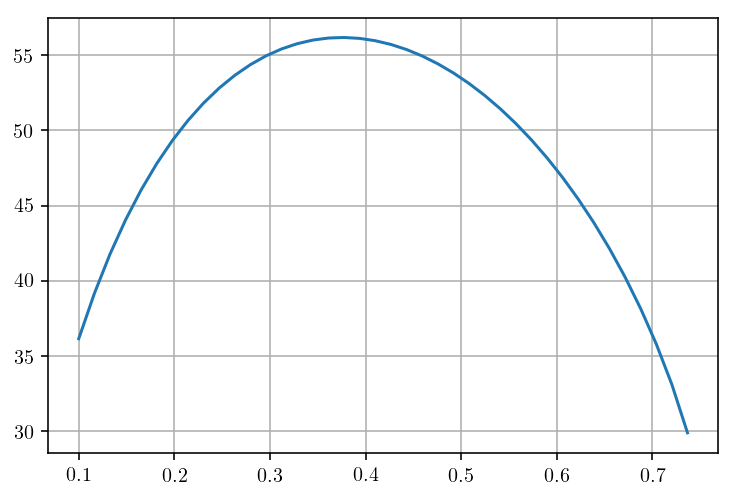

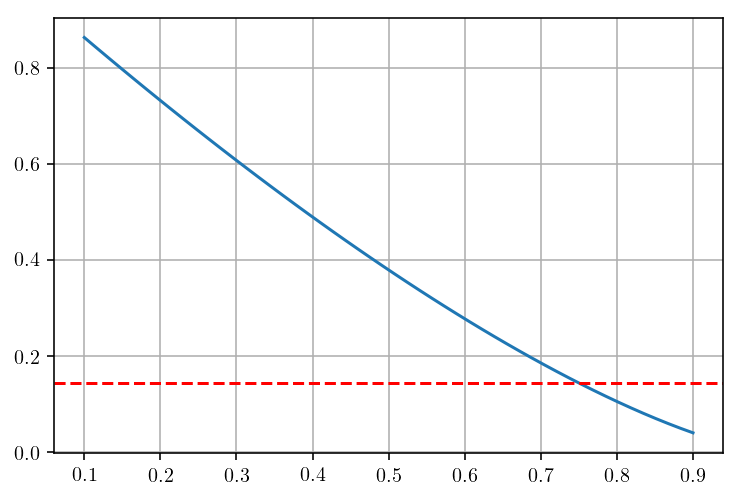

In [7]:
def integrate_trap(f, a, b, args=None, N=100):
    '''
    Uses trapezoidol rule to approximate
    integrate of f(x) from a to b
    '''
    delta_x = (b-a) / float(N)
    xk = np.linspace(a + delta_x, b - delta_x, N-1)
    return delta_x / 2. * (f(a, *args) + 2 * np.sum(f(xk, *args)) + f(b, *args))

def d_Ur_dmu(mu, rho_w, p0, pa, Vt, ms, alpha, n):
    return (Vt * np.sqrt(2. * rho_w * ((1. - alpha)**n * p0 * mu**(-n) - pa)) / 
            (rho_w * Vt * (1. - mu) + ms))

rho_w = 1000.        # kg / m^3
p0 = 7e5             # Pa
Vt = 2. * 1e-3       # m^3
pa = 1e5
ms = 0.1             # kg
n = 1.4
alphav = np.linspace(0.1, 0.9)
Delta_U_r = np.zeros_like(alphav)

pf = (1. - alphav)**n * p0

for i, a in enumerate(alphav):
    Delta_U_r[i] = integrate_trap(d_Ur_dmu, 1. - a, 1, args=(rho_w, p0, pa, Vt, ms, a, n))

plt.figure()
plt.plot(alphav, Delta_U_r)

plt.figure()
plt.plot(alphav, pf / p0)
plt.axhline(pa / p0, c='r', ls='--')

## Full Simulation

For this case, we will numerically integrate the trajectory of the rocket.  We will build a state-space model of the vehicle trajectory dynamics and the expulsion of mass from the rocket.  To start, with we will utilize

$$U_e = \sqrt{\frac{2 \left[p(t) - p_a\right]}{\rho_{w}}} = \sqrt{\frac{2 \left[p_0 (1-\alpha)^n \mu^{-n} - p_a\right]}{\rho_{w}}}$$

Now the governing state space equations are

$$\ddot{y} = \frac{\rho_w A_e U_e^2(\mu) - \frac{1}{2}C_dA_f\rho_a \dot{y}^2}{\rho_w V_t (1- \mu) + m_s} - g_0$$

$$\dot{\mu} = \frac{U_e(\mu) A_e}{V_t}$$

or in state-space representation:

$$\begin{gather}
    d\begin{bmatrix}
        \dot{y}\\
        y\\
        \mu
    \end{bmatrix} =  
    \begin{bmatrix}
        \frac{\rho_w A_e U_e^2(\mu) - \frac{1}{2}C_dA_f\rho_a \dot{y}^2}{\rho_w V_t (1- \mu) + m_s} - g_0\\
        \dot{y}\\
        \frac{U_e A_e}{V_t}
    \end{bmatrix}
\end{gather}$$

Assume $C_d = 0.4$ or [estimate using this](https://iopscience.iop.org/article/10.1088/0143-0807/30/5/012/pdf).

### Euler integration

For this analysis, we'll look at two different integration methods - Euler and midpoint.  They are both first-order, single-step explicit methods and are really the simplest of the numerical integration methods.

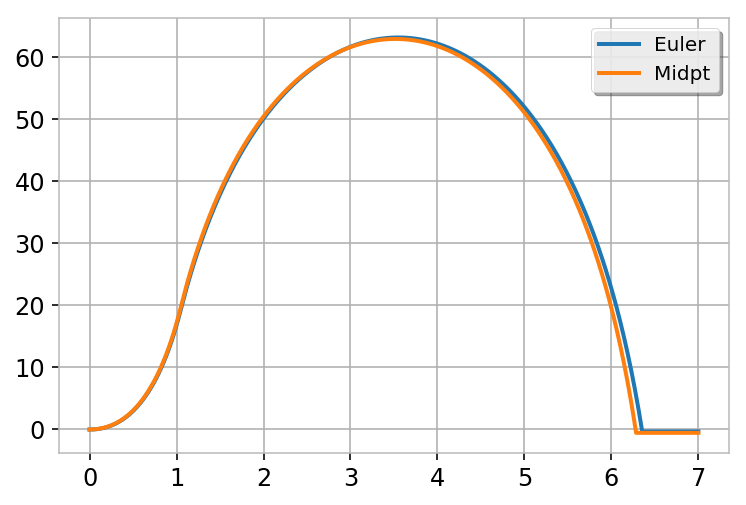

In [116]:
rho_a = 1.2           #kg/m^3
Cd = 0.4
Af = pi * (11e-2)**2 / 4.   # m^2
Ae = pi * (0.5e-2)**2 / 4.  # m^2
g0 = 9.81             # m/s^2
alpha = 0.35

def euler_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i], x[i-1, :])
    
    return t, x

def midpt_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    df_last = df0
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i] + dt / 2., x[i-1, :] + dt / 2. * df_last)
    
    return t, x

def df(t, x):
    yd = x[0]
    y = x[1]
    mu = x[2]
    dx = np.zeros([3])
    
    Ue = np.sqrt(2. * (p0 * (1 - alpha)**n * mu**(-n) - pa) / rho_w)
    
    # Check if we're out of water
    
    if y < 0.:
        dx[0] = 0.
        dx[1] = 0.
    elif mu >= 1.:
        dx[0] = ((- 0.5 * Cd * Af * rho_a * yd**2) /
             (rho_w * Vt * (1-mu) + ms) - g0)
        dx[1] = yd
        dx[2] = 0.
    else:
        dx[0] = ((rho_w * Ae * Ue**2 - 0.5 * Cd * Af * rho_a * yd**2) /
             (rho_w * Vt * (1-mu) + ms) - g0)
        dx[1] = yd
        dx[2] = Ue * Ae / Vt
        
    return dx

t, x = euler_integrate(df, 0, 7, [0, 0, 1. - alpha], N=500)
t1, x1 = midpt_integrate(df, 0, 7, [0, 0, 1. - alpha], N=500)
plt.plot(t, x[:,1], label='Euler')
plt.plot(t1, x1[:,1], label='Midpt')
plt.legend()

<a list of 12 text.Text objects>

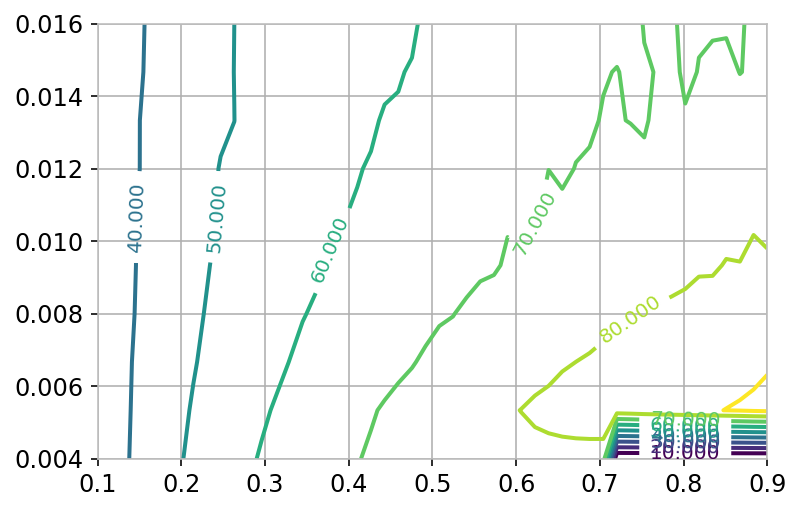

In [117]:
dt_v = np.linspace(0.4e-2, 1.6e-2, 10)

altv = np.zeros([len(dt_v), len(alphav)])

for i, d in enumerate(dt_v):
    for j, a in enumerate(alphav):
        alpha = a
        Ae = pi*d**2 / 4.
        t1, x1 = midpt_integrate(df, 0, 5, [0, 0, 1. - alpha], N=2000)
        altv[i, j] = np.max(x1[:, 1])
        
fig, ax = plt.subplots()
CS = ax.contour(alphav, dt_v, altv, 10)
ax.clabel(CS, inline=1, fontsize=10)